In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

# Environment

## Defining States

In [96]:
class State(object):
    def __init__(self, symbol, vector, is_terminal=False):
        self.symbol = symbol
        self.vector = vector
        self.right = None
        self.left = None
        self.is_terminal = is_terminal
    
    def set_neighbors(self, right, left):
        self.right = right
        self.left = left
        
    def __repr__(self):
        return self.symbol

In [97]:
symbols = "BCDEF"
n_symbols = len(symbols)

states = dict()
for i, symbol in enumerate(symbols):
    v = np.zeros((len(symbols), 1))
    v[i] = 1
    states[symbol] = State(symbol, v)

    # now we add their neighbors
for i, symbol in enumerate(symbols):
    state = states[symbol]
    if i > 0:
        state.left = states[symbols[i-1]]
    if i < len(symbols)-1:
        state.right = states[symbols[i+1]]
        
states["B"].left = State("A", vector=None, is_terminal=True)
states["F"].right = State("G", vector=None, is_terminal=True)

In [98]:
# show states and their neighbors
for s in states.values():
    print(f"{s.right} <- {s} -> {s.left}")

C <- B -> A
D <- C -> B
E <- D -> C
F <- E -> D
G <- F -> E


# Generating dataset

In [99]:
class Sequence(object):
    def __init__(self, states, reward):
        self.states = states
        self.reward = reward
        
    def get_symbols(self):
        return [s.symbol for s in self.states]
    
    def get_vectors(self):
        return [s.vector for s in self.states]
    
    def __repr__(self):
        return str([s for s in self.states])
    
    
class Dataset(object):
    def __init__(self, sequences):
        self.sequences = sequences
        
    def get_symbols(self):
        return [seq.get_symbols() for seq in self.sequences]
    
    def get_vectors(self):
        return [seq.get_vectors() for seq in self.sequences]
    
    def __repr__(self):
        return f"A dataset of {len(self.sequences)} sequences."

In [100]:
def random_walk(init_state="D"):
    seq = [states[init_state]]
    reward = None
    while reward is None:
        s = seq[-1]
        seq.append(s.left if np.random.random() < 0.5 else s.right)
        if seq[-1].symbol == "A": # next state
            reward = 0
        elif seq[-1].symbol == "G":
            reward = 1
    return Sequence(seq, reward)

In [101]:
n_sets = 100
n_sequences = 10 # episode

In [132]:
np.random.seed(42) # to make sure we are getting the same datasets

datasets = []
for i in range(n_sets):
    sequences = [random_walk() for _ in range(n_sequences)]
    datasets.append(Dataset(sequences))

datasets[0].sequences[0]

[D, C, D, E, F, E, D, C, D, E, F, E, F, G]

# Calculating the theoretical true value of $w$

In [133]:
I = np.identity(n_symbols)
Q = np.array([ # available transition probabilities without going to the terminal state
    # B  C  D  E  F
    [0, 0.5, 0, 0, 0],
    [0.5, 0, 0.5, 0, 0],
    [0, 0.5, 0, 0.5, 0],
    [0, 0, 0.5, 0, 0.5],
    [0, 0, 0, 0.5, 0]
])
h = np.array([0,0,0,0,0.5]).reshape(5,1) # true/ right hypothesis
w_star = np.dot(np.linalg.inv(I-Q), h) # true weight 
w_star

array([[0.16666667],
       [0.33333333],
       [0.5       ],
       [0.66666667],
       [0.83333333]])

# Training TD($\lambda$)

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-02_at_3.02.12_PM_Y0txTnB.png" width=400>

# Experiments

In [134]:
λ_vals = [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
rmse_vals = dict()

In [135]:
def fit_td_lambda(dataset, λ, max_iterations=1000, ϵ = 0.001):
    α = 0.01
    w = np.ones((n_symbols, 1))/2
    
    for iteration in range(max_iterations):
        old_w = w.copy()
        dw_total = np.zeros((n_symbols, 1)) # total delta w over all sequences within training dataset
        for seq in dataset.sequences:
            err = np.zeros((n_symbols, 1))
            dw = np.zeros((n_symbols, 1))
            for k, st in enumerate(seq.states[:-1]):
                st1 = seq.states[k+1]
                err = λ * err + st.vector
                if st1.is_terminal:
                    dw += α * (seq.reward - np.dot(w.T, st.vector)) * err
                else:
                    dw += α * (np.dot(w.T, st1.vector) - np.dot(w.T, st.vector)) * err
            dw_total += dw
        
        w += dw_total
        
        if (np.linalg.norm(old_w-w) <= ϵ):
            break
    return w

In [136]:
for λ in tqdm(λ_vals):
    rmse = 0
    for d in tqdm(datasets):
        w_hat = fit_td_lambda(d, λ)
        rmse += np.sqrt(np.mean((w_hat-w_star)**2))
    rmse_vals[λ] = rmse/len(datasets)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [137]:
rmse_vals

{0: 0.09904674232126519,
 0.1: 0.10066714048294786,
 0.3: 0.10446901610069824,
 0.5: 0.10959756243887998,
 0.7: 0.11826204331046798,
 0.9: 0.14036747558198875,
 1.0: 0.17440156270967666}

In [138]:
data = list(rmse_vals.items())
x = [i[0] for i in data]
y = [i[1] for i in data]

## Figure 3

In [139]:
def plot_error_vs_lambda(data, label=None, annotate=None):
    x = [i[0] for i in data]
    y = [i[1] for i in data]
    plt.plot(x, y, '-o', label=label)
    if annotate is not None:
        plt.annotate(annotate, xy=(1.0*0.8,y[-1]*0.98), fontsize=14)
    return fig

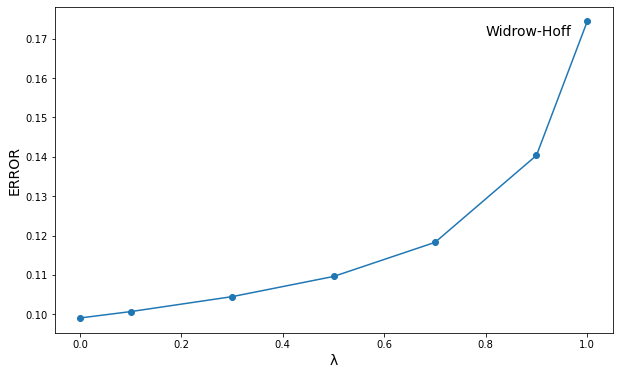

In [140]:
data = list(rmse_vals.items())
fig = plt.figure(figsize=(10,6))
plot_error_vs_lambda(data, annotate="Widrow-Hoff")
plt.ylabel("ERROR", fontsize=14)
plt.xlabel("λ", fontsize=14);

## Figure 4

In [141]:
# fit random walk using varying alphas and lambdas
def experiment_2(dataset, λ, α, max_iterations=1, ϵ = 0.001):
    w = np.ones((n_symbols, 1))/2
    
    for iteration in range(max_iterations):
        old_w = w.copy()
        for seq in dataset.sequences:
            err = np.zeros((n_symbols, 1))
            dw = np.zeros((n_symbols, 1))
            for k, st in enumerate(seq.states[:-1]):
                st1 = seq.states[k+1]
                err = λ * err + st.vector
                if st1.is_terminal:
                    dw += α * (seq.reward - np.dot(w.T, st.vector)) * err
                else:
                    dw += α * (np.dot(w.T, st1.vector) - np.dot(w.T, st.vector)) * err
            w += dw
        
        if (np.linalg.norm(old_w-w) <= ϵ):
            break
    return w

In [142]:
λ_vals = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
α_vals = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6]
rmse_vals2 = dict()

In [143]:
rmse_vals2 = dict()
for λ in tqdm(λ_vals):
    rmse_vals2[λ] = dict()
    for α in tqdm(α_vals):
        w_hats = Parallel(n_jobs=-1)(delayed(experiment_2)(d, λ, α) for d in datasets)
        rmse = 0
        for w_hat in w_hats:
            rmse += np.sqrt(np.mean((w_hat-w_star)**2))
        rmse_vals2[λ][α] = rmse/len(datasets) 

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [144]:
df = pd.DataFrame({"α": α_vals})
for λ in [0, 0.3, 0.8, 1]:
    df_temp = pd.DataFrame(rmse_vals2[λ].items(), columns=["α", f"λ={λ}"])
    df = df.merge(df_temp, on="α", how="left")
df

,α,λ=0,λ=0.3,λ=0.8,λ=1
0,0.00,0.235702,0.235702,0.235702,0.235702
1,0.05,0.174825,0.165998,0.152681,0.191294
2,0.10,0.130761,0.119894,0.121732,0.220198
3,0.15,0.102324,0.094304,0.125020,0.270073
4,0.20,0.089085,0.086671,0.145375,0.327883
5,0.25,0.092177,0.093327,0.170862,0.392216
6,0.30,0.121393,0.108404,0.198109,0.466678
7,0.35,0.207240,0.130492,0.228130,0.562103
8,0.40,0.426077,0.168760,0.266207,0.735113
9,0.45,0.965185,0.244785,0.324224,1.036934


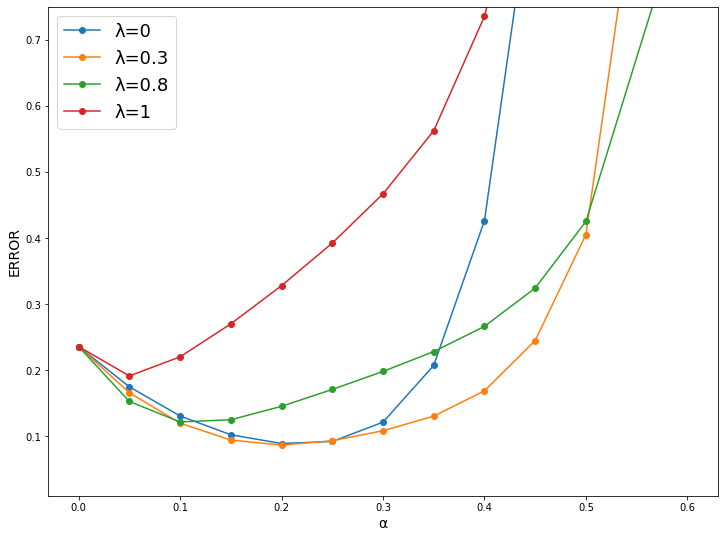

In [145]:
fig = plt.figure(figsize=(12, 9))
for λ in [0, 0.3, 0.8, 1]:
    data = list(rmse_vals2[λ].items())
    plot_error_vs_lambda(data, label=f"λ={λ}")
    
plt.ylabel("ERROR", fontsize=14)
plt.xlabel("α", fontsize=14)
plt.ylim(0.01, 0.75)
plt.legend(fontsize=18);

## Figure 5

In [146]:
df_all_λ = pd.DataFrame({"α": α_vals})
for λ in λ_vals:
    df_temp = pd.DataFrame(rmse_vals2[λ].items(), columns=["α", f"λ={λ}"])
    df_all_λ = df_all_λ.merge(df_temp, on="α", how="left")
df_all_λ

,α,λ=0,λ=0.1,λ=0.2,λ=0.3,λ=0.4,λ=0.5,λ=0.6,λ=0.7,λ=0.8,λ=0.9,λ=1.0
0,0.00,0.235702,0.235702,0.235702,0.235702,0.235702,0.235702,0.235702,0.235702,0.235702,0.235702,0.235702
1,0.05,0.174825,0.172009,0.169066,0.165998,0.162825,0.159604,0.156478,0.153811,0.152681,0.157135,0.191294
2,0.10,0.130761,0.127038,0.123382,0.119894,0.116756,0.114294,0.113125,0.114548,0.121732,0.143904,0.220198
3,0.15,0.102324,0.099060,0.096312,0.094304,0.093420,0.094305,0.098094,0.106873,0.125020,0.163878,0.270073
4,0.20,0.089085,0.087016,0.086134,0.086671,0.089153,0.094433,0.103647,0.118998,0.145375,0.195625,0.327883
5,0.25,0.092177,0.089663,0.090323,0.093327,0.098699,0.107110,0.119888,0.139271,0.170862,0.230436,0.392216
6,0.30,0.121393,0.107605,0.105233,0.108404,0.115050,0.125245,0.140065,0.162086,0.198109,0.267334,0.466678
7,0.35,0.207240,0.152270,0.133154,0.130492,0.136218,0.147133,0.163269,0.187516,0.228130,0.308772,0.562103
8,0.40,0.426077,0.259725,0.191920,0.168760,0.167170,0.176991,0.193797,0.220342,0.266207,0.360523,0.735113
9,0.45,0.965185,0.501660,0.318798,0.244785,0.224125,0.228504,0.243551,0.271714,0.324224,0.437876,1.036934


In [147]:
error_with_best_alpha = df_all_λ.min()[1:].reset_index().rename(columns={"index":"λ", 0:"ERROR"})
error_with_best_alpha["λ"] = error_with_best_alpha.λ.str.replace("λ=", "").astype(float)
error_with_best_alpha

,λ,ERROR
0,0.0,0.089085
1,0.1,0.087016
2,0.2,0.086134
3,0.3,0.086671
4,0.4,0.089153
5,0.5,0.094305
6,0.6,0.098094
7,0.7,0.106873
8,0.8,0.121732
9,0.9,0.143904


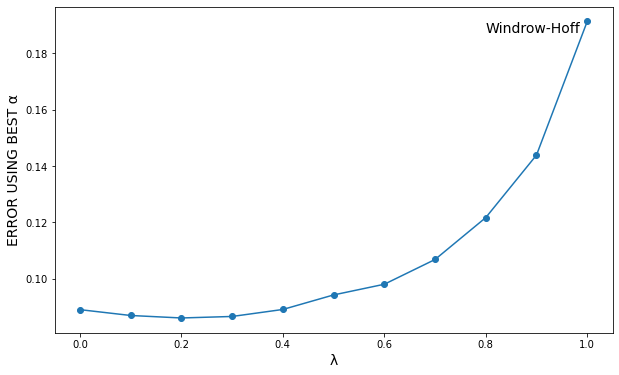

In [149]:
data = list(zip(error_with_best_alpha.λ, error_with_best_alpha.ERROR))
fig = plt.figure(figsize=(10, 6))
plot_error_vs_lambda(data, annotate="Windrow-Hoff")
plt.ylabel("ERROR USING BEST α", fontsize=14)
plt.xlabel("λ", fontsize=14);

In [1]:
!jupyter nbconvert --to script Project_1.ipynb

[NbConvertApp] Converting notebook Project_1.ipynb to script
[NbConvertApp] Writing 7734 bytes to Project_1.py
